<a href="https://colab.research.google.com/github/hyeonji826/AI/blob/main/%EC%83%9D%EC%84%B1%ED%98%95%20AI/20_ViT(Vistion_Transformer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. ViT(Vistion Transformer)
ViT(Vision Transformer)는 이미지를 일정 크기의 패치(예: 16×16)로 나눈 뒤 각 패치를 임베딩 벡터로 투영해 토큰 시퀀스로 만들고, 여기에 위치 임베딩을 더해 트랜스포머 인코더(멀티헤드 자기어텐션+FFN)로 처리하여 분류 등의 다운스트림 작업을 수행하는 모델입니다. 분류의 경우 BERT처럼 맨 앞에 [CLS] 토큰을 두고 그 출력으로 최종 예측을 합니다. CNN이 지역적 합성곱과 계층적 다운샘플링으로 전역 정보를 “깊이”에서 얻게 되는 반면, ViT는 자기어텐션으로 처음부터 전역 관계를 직접 학습하는 것이 특징입니다. 충분한 데이터와 적절한 사전학습·증강이 있을 때 스케일이 클수록 성능이 잘 향상되지만, 어텐션의 계산량이 토큰 수 제곱(O(N²))에 비례해 해상도가 높거나 패치가 너무 작으면 비용이 크게 늘 수 있습니다.

<img src="https://blog.kakaocdn.net/dna/kZlqc/btsQg90MpsJ/AAAAAAAAAAAAAAAAAAAAAJTnKQC5Fews_HwVpTRIo6VAcuh3yWOriDi8PqJGWqpu/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=CI6c%2FMDl8WUER%2Bj9v3UX6yazoXo%3D" width=800>

## 2. ViT VS CNN
ViT와 CNN의 핵심 차이는 표현 방식과 연산에 있습니다. CNN은 연속된 이미지 위에 합성곱 커널을 슬라이딩해 국소 패턴을 단계적으로 통합하며, 구조 자체에 국소성·평행이동 불변성이라는 강한 귀납적 편향이 있어 적은 데이터에서도 안정적으로 학습합니다. 반면 ViT는 이미지를 패치 토큰으로 바꿔 Self-Attention으로 처음부터 전역 관계를 학습하며, 위치 정보를 위해 포지션 임베딩이 필요하고 대규모 데이터·강한 증강/사전학습에 더 의존합니다. 계산 측면에서 CNN은 대체로 입력 크기에 선형적으로 늘지만, ViT의 어텐션은 토큰 수에 대해 O(N²)로 증가해 고해상도에서 비용이 커집니다. 분류 단계에서도 CNN은 보통 GAP→작은 FC로 마무리하는 반면, ViT는 [CLS] 토큰(또는 토큰 풀링)→MLP 헤드를 사용합니다. 전체적으로 소규모·엣지 환경은 CNN이 유리하고, 대규모 데이터·모델 스케일업에서는 ViT가 강점을 보입니다.

<img src="https://blog.kakaocdn.net/dna/bty7kf/btsQgfUHyOT/AAAAAAAAAAAAAAAAAAAAAG3dpfM3VhlwzhP2cWR356uWc8o02kdDTZ-EvhCIl9fR/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=rbk3PgNdYTdR%2B1FuVYC49xfFINo%3D" width=800>

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
image = np.random.rand(8, 8, 3)  # -> (4,4,4,3)
# ndarray는 기본으로 (H, W, C)

In [3]:
# 8*8 이미지를 4*4 크기의 패치로 2*2 그리드(총 4개)로 쪼개어 (패치개수, 패치H, 패치W, 채널) 형태로 만듦
# (4, 4, 4, 3)
# (패치행 수, 패치 내부 세로, 패치열 수, 패치 내부 가로, 채널) -> (2, 4, 2, 4, 3)
image = image.reshape(2, 4, 2, 4, 3)
# 너무 작아도 성능이 좋지 않음 -> 적당히..?

# (8,8,3) = (4,4,4,3) =(2,4,2,4,3)

In [4]:
# 패치 수 끼리, 패치 내부 가로세루 끼리 모아서 정리한 것
image = image.transpose(0, 2, 1, 3, 4)  # (2,2,4,4,3)
patches = image.reshape(-1, 4, 4, 3)

print(patches.shape)

(4, 4, 4, 3)


In [5]:
# PyTorch의 Conv2d에 넣으려면 이후 CHW(NCHW) 변환(예: permute)과 배치 차원 추가가 필요함.
patches = torch.Tensor(patches)

In [6]:
embedding_dim = 32
num_heads = 4
num_transformer_layers = 2
num_mlp_layers = 2  # 보통 fc가 위치하는 있는 MLP
num_classes = 10
mlp_dim = 256

In [7]:
# 4 4 4 3 -> (N,C,H,W) -> permute 해서 순서 바꿔주는
def patch_embedding(patches, embedding_dim):
    input_projection_layer = nn.Conv2d(in_channels=3, out_channels=embedding_dim,
                                       kernel_size=patches.shape[1], stride=patches.shape[1])
    num_patches_row, num_patches_col = int(patches.shape[0]/2), int(patches.shape[0]/2)

    x = patches.reshape(patches.shape[1] * num_patches_row, patches.shape[2] * num_patches_col, 3).permute(2, 0, 1)
    print(x.shape)   # 3, 8, 8
    x = x.unsqueeze(0) # 1, 3, 8 ,8
    print(x.shape)
    patch_projected = input_projection_layer(x).squeeze(0)
    return patch_projected

In [8]:
embedded_patches = patch_embedding(patches, embedding_dim)
print(embedded_patches.shape)

torch.Size([3, 8, 8])
torch.Size([1, 3, 8, 8])
torch.Size([32, 2, 2])


In [9]:
def add_pos_embedding(embedded_patches, embedding_dim):
    pos = (torch.empty(embedded_patches.shape[1], embedded_patches.shape[2], embedding_dim)
           .normal_(std=0.02))  # from BERT -> 정규 분포 값으로 초기값을 초기화
    pos_embedding = nn.Parameter(pos).permute(2, 0, 1)  # (embedding_dim, H, W )
    return embedded_patches + pos_embedding # 위치정보를 같이 넣어주기 위해서

hidden = add_pos_embedding(embedded_patches, embedding_dim)
hidden.shape

# 패치 초기화 (pos_embedding) : 이미지를 패치 단위로 잘라서 토큰화 -> 이미지의 피처를 각 패치 단위에 보존시킴
# 그 다음에 패치가 원래 어디에 있었는지 트렌스포머가 알 수 있도록 위치 정보를 인코딩
#“초기화”는 패치를 토큰으로 변환해서 Transformer가 처리할 수 있는 형태로 만드는 과정
# CNN에서 쓰는 커널 초기화 개념과 다르고, RNN의 hidden state 초기화 개념이랑 헷갈리지 말자!

torch.Size([32, 2, 2])

In [10]:
transformer_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)
transformer_encoder = nn.TransformerEncoder(transformer_layers, num_layers=num_transformer_layers)

hidden = hidden.reshape((embedding_dim, -1)).permute(1, 0)
print(hidden.reshape)
encoded_patches = transformer_encoder(hidden)
print(encoded_patches.shape)
# 공간 정보를 알기 위해 각각의 패치를 초기화해서 하나씩 패치를 쌓는다. = RNN과 유사하면서 다름
# CNN 구조이긴 하나 통째로 넣는 것이 아니라 패티 하나하나 넣어서 피처를 뽑아낸다.

<built-in method reshape of Tensor object at 0x7bf237c8ff70>
torch.Size([4, 32])


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


<img src="https://blog.kakaocdn.net/dna/od692/btsQiJGN90G/AAAAAAAAAAAAAAAAAAAAAHhzjiwZKS4Hm00Sk_IaddHet4lT0A7Je1b--PaE2X-C/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=PLhXJnRRp6e30ziLkOHzywAPaI0%3D">

In [11]:
mlp = nn.Sequential(
    nn.Linear(embedding_dim, mlp_dim),
    nn.GELU(),
    nn.Linear(mlp_dim, embedding_dim)
)

encoded_patches = mlp(encoded_patches)

In [12]:
classification_layer = nn.Linear(embedding_dim, num_classes)
output = F.log_softmax(classification_layer(encoded_patches.mean(dim=0)), dim=-1)
output

tensor([-2.4198, -2.2834, -2.1601, -2.3339, -2.3353, -2.2150, -2.3359, -2.4793,
        -2.2455, -2.2580], grad_fn=<LogSoftmaxBackward0>)

In [13]:
print("class : ", output.topk(1)[1].item())

class :  2


## 3. 번호판 분류하기
AI-Hub의 “자동차 차종/연식/번호판 인식용 영상”은 시내도로·주유소·주차장 CCTV 영상에서 차량 차종·연식·번호판을 식별하는 AI 학습용 데이터셋으로, 2020년에 구축되어 2022년 갱신되었습니다. 수집된 약 2,189시간의 영상을 이미지로 추출해 차량 바운딩박스를 만들고, 차량 크롭 이미지 50만 장(+ 차종/색상/제조사/연식 JSON 50만 개)과 번호판 크롭 이미지 10만 장(+ 번호값 JSON 10만 개)으로 제공됩니다. 대표 과제는 차량 속성 분류와 번호판 OCR이며, 안내된 예시 성능은 번호판 OCR 정확도 99.75%(CRAFT+STR), 차량 연식/모델식별 mAP 86%(YOLOv3)입니다.

In [23]:
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/ViT"

!unzip -q "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/ViT.zip" -d "/content/"

In [15]:
import os
import pandas as pd
from tqdm import tqdm
import json

In [24]:
data_root = '/content/'
annotation_filename = 'annotations.json'
image_dir = os.path.join(data_root, 'images')

In [25]:
with open(os.path.join(data_root, annotation_filename), 'r')as json_f:
    annotations = json.load(json_f)
annotations[:3]

[{'filename': '21구2298.jpg', 'labels': '2298'},
 {'filename': '89고2055.jpg', 'labels': '2055'},
 {'filename': '334도2103.jpg', 'labels': '2103'}]

In [26]:
print('데이터 개수 :', len(annotations))

데이터 개수 : 36828


In [27]:
import json
from collections import defaultdict

digit1_cnt = defaultdict(int)
digit2_cnt = defaultdict(int)
digit3_cnt = defaultdict(int)
digit4_cnt = defaultdict(int)

for annot in annotations:
    labels = annot['labels']

    digit1_cnt[labels[0]] += 1
    digit2_cnt[labels[1]] += 1
    digit3_cnt[labels[2]] += 1
    digit4_cnt[labels[3]] += 1

In [28]:
with open('digit1_cnt.json', 'w')as json_f:
    json.dump(digit1_cnt, json_f, indent='\t', ensure_ascii=False)
with open('digit2_cnt.json', 'w')as json_f:
    json.dump(digit2_cnt, json_f, indent='\t', ensure_ascii=False)
with open('digit3_cnt.json', 'w')as json_f:
    json.dump(digit3_cnt, json_f, indent='\t', ensure_ascii=False)
with open('digit4_cnt.json', 'w')as json_f:
    json.dump(digit4_cnt, json_f, indent='\t', ensure_ascii=False)

digit1_cnt

defaultdict(int,
            {'2': 3617,
             '5': 4056,
             '6': 4110,
             '7': 3340,
             '0': 3978,
             '3': 3505,
             '4': 3611,
             '8': 3535,
             '9': 2985,
             '1': 4091})

In [29]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

'''
    json 데이터를 파싱하는 커스텀 데이터세트 클래스를 선언한다.
'''

class JsonDataset(Dataset):
    def __init__(self,
                 image_dir,
                 annotations,
                 transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.class_list = [i for i in range(10)] # 클래스의 목록 (0, 1, ..., 9)
        self.num_classes = len(self.class_list) # 클래스 개수


    def __len__(self):
        return len(self.annotations) # 데이터 개수

    def __getitem__(self, idx):
        '''
            :param idx:
            :return:
                image : 입력 이미지 데이터 (텐서 또는 pillow 이미지)
                target : 클래스 번호 목록
                        예) [1, 9, 0, 3]
        '''
        annot = self.annotations[idx]
        filename = annot['filename']
        classes = annot['labels']

        image_path = os.path.join(self.image_dir, filename)
        image = Image.open(image_path).convert("RGB")

        target_list = []
        for cls in classes: ## '1024' -> '1', '0', '2', '4'
            target_list.append(int(cls))
        target_list = torch.Tensor(target_list).to(torch.long)

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, target_list

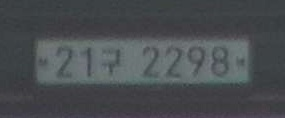

In [30]:
dataset = JsonDataset(image_dir=image_dir,
                      annotations=annotations)
data = dataset[0]
data[0]

In [31]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def draw_images(images, classes):
    '''
        :param images: cv2(ndarray) 이미지 리스트
        :param classes: 클래스 리스트
        :return: None
    '''

    # 4x2의 그리드 생성 (바둑판 이미지 틀 생성)
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))

    # 각 하위 그래프에 이미지 출력
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i]) # 이미지를 바둑판에 출력
        ax.set_title(classes[i]) # 클래스 이름으로 이미지 제목 생성
        # ax.axis('off') # 축 숨기기

    plt.tight_layout()
    plt.show()

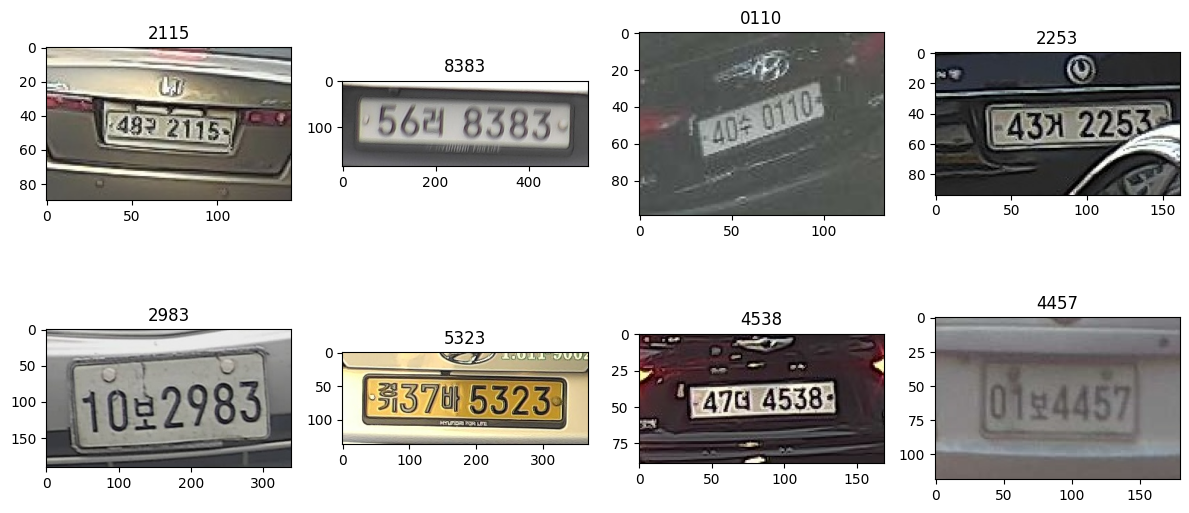

In [32]:
from PIL import Image
import numpy as np
import random

random.shuffle(annotations)

sample_images = [] # 이미지 샘플 저장
sample_classes = [] # 이미지 클래스 저장
sample_cnt = 0 # 시작 count
max_cnt = 8 # 종류 count
for annot in annotations:
    sample_classes.append(annot['labels'])
    image_path = os.path.join(image_dir, annot['filename'])
    image = Image.open(image_path).convert('RGB')
    sample_images.append(np.array(image))
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

## 전체 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

In [33]:
sample_classes

['2115', '8383', '0110', '2253', '2983', '5323', '4538', '4457']

In [34]:
len_annot = len(annotations)
train_annot = annotations[ : int(len_annot * 0.9)]
val_annot = annotations[int(len_annot * 0.9) : ]

print(f'학습 데이터 개수 : {len(train_annot)}')
print(f'검증 데이터 개수 : {len(val_annot)}')

학습 데이터 개수 : 33145
검증 데이터 개수 : 3683


In [35]:
hyper_params = {
    'num_epochs': 3,
    'lr': 0.0001,
    'image_size': 224,
    'train_batch_size': 32,
    'val_batch_size': 16,
    'print_preq': 0.1 # 학습 중 로그 출력 빈도
}

In [36]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 샘플 이미지 변환 모듈 설정
sample_transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=15, shift_limit=0.05, scale_limit=0.1, p=0.5, border_mode=0),
    # A.HorizontalFlip(p=0.5),
    A.LongestMaxSize(max_size=hyper_params['image_size'],
                     always_apply=True),
    A.PadIfNeeded(min_height=hyper_params['image_size'],
                  min_width=hyper_params['image_size'],
                  always_apply=True,
                  border_mode=0),
    # A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    # ToTensorV2() ## 모델에 입력할 때 사용
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2504639754.py:8: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  A.LongestMaxSize(max_size=hyper_params['image_size'],
/tmp/ipython-input-2504639754.py:10: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=hyper_params['image_size'],


In [37]:
sample_dataset = JsonDataset(image_dir=image_dir,
                             annotations=annotations,
                             transform=sample_transform)

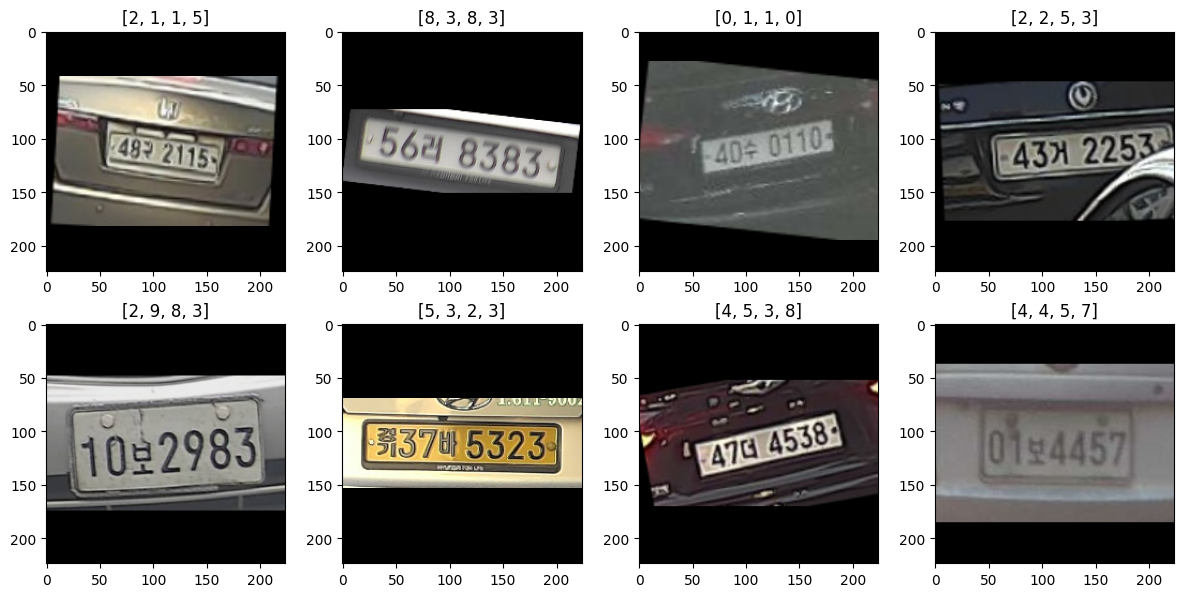

In [38]:
transformed_images = []
targets = []

## 데이터세트에서 변환된 이미지와 target 벡터를 불러온다.
max_cnt = 8
for idx, (image, target) in enumerate(sample_dataset):
    if idx == max_cnt:
        break
    transformed_images.append(image)
    targets.append(target.tolist())

## 타켓 벡터를 클래스로 변환하고
target_classes = []
class_list = sample_dataset.class_list
for target in targets:
    classes = []
    for cls in target:
        classes.append(class_list[cls])
    target_classes.append(classes)

draw_images(transformed_images, target_classes)

In [39]:
# 학습 및 검증 이미지 변환 모듈 설정
train_transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=15, shift_limit=0.05, scale_limit=0, p=0.5, border_mode=0),
    # A.HorizontalFlip(p=0.5),
    A.LongestMaxSize(max_size=hyper_params['image_size'],
                     always_apply=True),
    A.PadIfNeeded(min_height=hyper_params['image_size'],
                  min_width=hyper_params['image_size'],
                  always_apply=True,
                  border_mode=0),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

val_transform = A.Compose([
    A.LongestMaxSize(max_size=hyper_params['image_size'],
                     always_apply=True),
    A.PadIfNeeded(min_height=hyper_params['image_size'],
                  min_width=hyper_params['image_size'],
                  always_apply=True,
                  border_mode=0),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

# 학습 데이터세트 및 데이터로더 설정
train_dataset = JsonDataset(image_dir=image_dir,
                             annotations=train_annot,
                             transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, num_workers=4,
                                               batch_size=hyper_params['train_batch_size'], shuffle=True)

# 검증 데이터세트 및 데이터로더 설정
val_dataset = JsonDataset(image_dir=image_dir,
                          annotations=val_annot,
                          transform=val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4,
                                             batch_size=hyper_params['val_batch_size'], shuffle=False)

/tmp/ipython-input-1884573.py:5: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  A.LongestMaxSize(max_size=hyper_params['image_size'],
/tmp/ipython-input-1884573.py:7: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=hyper_params['image_size'],
/tmp/ipython-input-1884573.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  A.LongestMaxSize(max_size=hyper_params['image_size'],
/tmp/ipython-input-1884573.py:18: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=hyper_params['image_size'],
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation

In [40]:
import torch.nn as nn
import timm

class ViTMultiBranchClassifier(nn.Module):
    def __init__(self, num_classes, num_branches, model_name='vit_base_patch16_224', pretrained=True):
        super(ViTMultiBranchClassifier, self).__init__()

        # ViT 모델 로드
        self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.branches = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(self.vit.embed_dim, 256),
                    nn.GELU(),
                    nn.Dropout(0.3),
                    nn.Linear(256, num_classes)
                )
                for _ in range(num_branches)
            ]
        )   # 여기까지 초기화 과정임

    def forward(self, x):
        # ViT 모델을 통해 이미지 특징 추출
        features = self.vit(x)
        # 각 분기별로 특징을 입력으로 받아 예측 수행
        outputs = [branch(features) for branch in self.branches]

        return outputs

In [41]:
num_branches = 4
num_classes = train_dataset.num_classes
# num_classes=10
model = ViTMultiBranchClassifier(num_classes=num_classes, num_branches=num_branches)
model

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTMultiBranchClassifier(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
  

In [42]:
import torch

sample_input = torch.randn(1, 3 ,224 ,224)
model(sample_input)[1]

tensor([[ 0.0747,  0.1901,  0.2081, -0.3246,  0.1288, -0.1601,  0.1734, -0.0541,
          0.1450, -0.1250]], grad_fn=<AddmmBackward0>)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score


def calculate_accuracy(y_pred, y_true):
    """예측값과 실제값이 주어졌을 때 정확도 계산"""
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy


# loss 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = hyper_params['num_epochs']

model_save_dir = './part2_chapter31_train_results'

best_acc = 0.0
# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

    for idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)

        # forward
        outputs = model(images)
        total_loss = 0  # 전체 손실 초기화
        for branch_idx, output in enumerate(outputs):
            loss = nn.CrossEntropyLoss()(output, targets[:, branch_idx])
            total_loss += loss


        # backward & update
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        epoch_loss += total_loss.item()

        if (idx > 0) and (idx % print_cnt) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {(running_loss/print_cnt)/num_branches:.4f}")
            running_loss = 0.0


    # 한 epoch이 끝날 때마다 loss 총 합 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")

    accuracies = [[] for _ in range(num_branches)]  # 각 브랜치별 정확도를 저장할 리스트

    model.eval()
    with torch.no_grad():
        for images, targets in val_dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)  # 모델로부터 여러 브랜치의 출력 받기
            for i, output in enumerate(outputs):
                accuracy = calculate_accuracy(output, targets[:, i])
                accuracies[i].append(accuracy.item())

    # 각 브랜치별 평균 정확도 계산 및 출력
    total_acc = 0.0
    for idx, acc_list in enumerate(accuracies):
        mean_accuracy = sum(acc_list) / len(acc_list)
        total_acc += mean_accuracy
        print(f"Branch {idx + 1} Accuracy: {mean_accuracy*100:.2f}%")

    if total_acc > best_acc:
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, 'best_model.pth')

        torch.save(model.state_dict(), model_save_path)
        best_acc = total_acc

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/3], Iter [103/1036] Loss: 2.3375
Epoch [1/3], Iter [206/1036] Loss: 2.3089
Epoch [1/3], Iter [309/1036] Loss: 2.3018
Epoch [1/3], Iter [412/1036] Loss: 2.3027
Epoch [1/3], Iter [515/1036] Loss: 2.2974
Epoch [1/3], Iter [618/1036] Loss: 2.2885
Epoch [1/3], Iter [721/1036] Loss: 2.1868
Epoch [1/3], Iter [824/1036] Loss: 2.0258
Epoch [1/3], Iter [927/1036] Loss: 1.9170
Epoch [1/3], Iter [1030/1036] Loss: 1.8116
Epoch [1/3], Loss: 8.6915
Branch 1 Accuracy: 89.71%
Branch 2 Accuracy: 59.05%
Branch 3 Accuracy: 16.32%
Branch 4 Accuracy: 9.50%
Epoch [2/3], Iter [103/1036] Loss: 1.5569
Epoch [2/3], Iter [206/1036] Loss: 1.2051
Epoch [2/3], Iter [309/1036] Loss: 0.8095
Epoch [2/3], Iter [412/1036] Loss: 0.4728
Epoch [2/3], Iter [515/1036] Loss: 0.3387
Epoch [2/3], Iter [618/1036] Loss: 0.2794
Epoch [2/3], Iter [721/1036] Loss: 0.2556
Epoch [2/3], Iter [824/1036] Loss: 0.1986
Epoch [2/3], Iter [927/1036] Loss: 0.1839
Epoch [2/3], Iter [1030/1036] Loss: 0.1665
Epoch [2/3], Loss: 2.1778
Bra

In [ ]:
import torch
from torchvision.transforms.functional import to_pil_image

def denormalize(tensor, mean, std):
    '''
        텐서를 역정규화 한다.
    '''
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)

    # 역정규화 수행
    tensor = tensor * std + mean

    # 텐서의 값 범위를 0과 1 사이로 조정합니다.
    tensor = torch.clamp(tensor, 0, 1)

    return tensor

def tensor_to_pil(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    '''
        정규화된 텐서를 Pillow 이미지로 변환한다.
    '''
    # 역정규화
    tensor = denormalize(tensor, mean, std)

    # 텐서를 Pillow 이미지로 변환한다.
    pil_image = to_pil_image(tensor)

    return pil_image

In [ ]:
model_save_dir = 'vit_train_results'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_branches = 4
num_classes = 10
class_list = [str(i) for i in range(10)]
model = ViTMultiBranchClassifier(num_classes=num_classes, num_branches=num_branches).eval().to(device)
weight = torch.load(os.path.join(model_save_dir, 'best_model.pth'), map_location='cpu')
model.load_state_dict(weight)

eval_cnt = 8
model.eval()
pred_class_list = []
input_image_list = []
with torch.no_grad():
    for idx, (images, targets) in enumerate(val_dataloader):
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)  # 모델로부터 여러 브랜치의 출력 받기

        input_image_list.append(tensor_to_pil(images[0].detach().cpu()))

        pred_classes = []
        for i, output in enumerate(outputs):
            output = output[0]
            predicted = torch.argmax(output)
            pred_classes.append(class_list[int(predicted)])
        pred_class_list.append("".join(pred_classes))

        if (idx+1) == eval_cnt:
            break

In [ ]:
pred_class_list

In [ ]:
draw_images(input_image_list, pred_class_list)